In [1]:
import tensorflow as tf

In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.misc

In [3]:
sys.path.append('/root/Work/CogFashion/cftfmodels/')

In [4]:
#from alexnet.base.models import conv
from alexnet.base.models import *
from alexnet.base.caffe_classes import class_names

In [5]:
def fc(x, num_in, num_out, name, relu = True,stdv=0.01):
    with tf.variable_scope(name) as scope:
    
        # Create tf variables for the weights and biases
        weights = tf.get_variable('weights', shape=[num_in, num_out], trainable=True,
                              initializer = tf.truncated_normal_initializer(stddev=stdv))
        biases = tf.get_variable('biases', [num_out], trainable=True,
                             initializer = tf.constant_initializer(0.000))
    
        # Matrix multiply weights and inputs and add bias
        act = tf.nn.xw_plus_b(x, weights, biases, name=scope.name)
    
        if relu == True:
            # Apply ReLu non linearity
            relu = tf.nn.relu(act)      
            return relu
        else:
            return act
    



In [6]:
"""
Predefine all necessary layer for the AlexNet
""" 
def conv(x, filter_height, filter_width, num_filters, stride_y, stride_x, name,
         padding='SAME', groups=1,weights_std = 0.1, bias_value = 0.001):
    """
      Adapted from: https://github.com/ethereon/caffe-tensorflow
    """
    # Get number of input channels
    input_channels = int(x.get_shape()[-1])
  
    # Create lambda function for the convolution
    convolve = lambda i, k: tf.nn.conv2d(i, k, 
                                       strides = [1, stride_y, stride_x, 1],
                                       padding = padding)
  
    with tf.variable_scope(name) as scope:
        # Create tf variables for the weights and biases of the conv layer
        shape = [filter_height, filter_width,
                              input_channels/groups, num_filters]
        weights = tf.get_variable('weights', shape = shape,
                                  initializer = tf.truncated_normal_initializer(stddev=weights_std))
        shape = [num_filters]
        biases = tf.get_variable('biases', shape = shape,
                                 initializer = tf.constant_initializer(value = bias_value))  
    
    
        if groups == 1:
            conv = convolve(x, weights)
            # In the cases of multiple groups, split inputs & weights and
        else:
            # Split input and weights and convolve them separately
            input_groups = tf.split(axis = 3, num_or_size_splits=groups, value=x)
            weight_groups = tf.split(axis = 3, num_or_size_splits=groups, value=weights)
            output_groups = [convolve(i, k) for i,k in zip(input_groups, weight_groups)]
      
            # Concat the convolved output together again
            conv = tf.concat(axis = 3, values = output_groups)
      
        # Add biases 
        bias = tf.reshape(tf.nn.bias_add(conv, biases), conv.get_shape().as_list())
    
        # Apply relu function
        relu = tf.nn.relu(bias, name = scope.name)
        
    return relu
  


In [7]:
def max_pool(x, filter_height, filter_width, stride_y, stride_x, name, padding='SAME'):
    return tf.nn.max_pool(x, ksize=[1, filter_height, filter_width, 1],
                        strides = [1, stride_y, stride_x, 1],
                        padding = padding, name = name)
  


In [8]:
def lrn(x, radius, alpha, beta, name, bias=1.0):
    return tf.nn.local_response_normalization(x, depth_radius = radius, alpha = alpha,
                                            beta = beta, bias = bias, name = name)
 

In [9]:
 
def dropout(x, keep_prob):
    return tf.nn.dropout(x, keep_prob)
  

In [10]:
inp = tf.placeholder(tf.float32,[1,256,256,3])
keep_prob = tf.placeholder(tf.float32,None)
num_classes = 1000


In [11]:
with tf.variable_scope('alex_net') as sc:
     # 1st Layer: Conv (w ReLu) -> Pool -> Lrn
    conv1 = conv(inp, 11, 11, 96, 4, 4, padding = 'VALID', name = 'conv1')
    pool1 = max_pool(conv1, 3, 3, 2, 2, padding = 'VALID', name = 'pool1')
    norm1 = lrn(pool1, 2, 2e-05, 0.75, name = 'norm1')
    #self.conv1 = conv1
    # 2nd Layer: Conv (w ReLu) -> Pool -> Lrn with 2 groups
    conv2 = conv(norm1, 5, 5, 256, 1, 1, groups = 2, name = 'conv2')
    pool2 = max_pool(conv2, 3, 3, 2, 2, padding = 'VALID', name ='pool2')
    norm2 = lrn(pool2, 2, 2e-05, 0.75, name = 'norm2')
    #self.conv2 = conv2
    # 3rd Layer: Conv (w ReLu)
    conv3 = conv(norm2, 3, 3, 384, 1, 1, name = 'conv3')
    #self.conv3 = conv3
    # 4th Layer: Conv (w ReLu) splitted into two groups
    conv4 = conv(conv3, 3, 3, 384, 1, 1, groups = 2, name = 'conv4')
    #self.conv4 = conv4
    
    # 5th Layer: Conv (w ReLu) -> Pool splitted into two groups
    conv5 = conv(conv4, 3, 3, 256, 1, 1, groups = 2, name = 'conv5')
    #self.c5 = conv5
    pool5 = max_pool(conv5, 3, 3, 2, 2, padding = 'VALID', name = 'pool5')
    
    # 6th Layer: Flatten -> FC (w ReLu) -> Dropout
    flattened = tf.reshape(pool5, [-1, 6*6*256])
    conv5 = pool5
    fc6 = fc(flattened, 6*6*256, 4096, name='fc6')
    dropout6 = dropout(fc6, keep_prob)
    
    # 7th Layer: FC (w ReLu) -> Dropout
    fc7 = fc(dropout6, 4096, 4096, name = 'fc7')
    dropout7 = dropout(fc7, keep_prob)
    #self.fc7 = dropout7
    # 8th Layer: FC and return unscaled activations (for tf.nn.softmax_cross_entropy_with_logits)
    fc8 = fc(dropout7, 4096, num_classes, relu = False, name='fc8')
    sc.reuse_variables()

In [12]:
for v in tf.trainable_variables():
    print(v)

<tf.Variable 'alex_net/conv1/weights:0' shape=(11, 11, 3, 96) dtype=float32_ref>
<tf.Variable 'alex_net/conv1/biases:0' shape=(96,) dtype=float32_ref>
<tf.Variable 'alex_net/conv2/weights:0' shape=(5, 5, 48, 256) dtype=float32_ref>
<tf.Variable 'alex_net/conv2/biases:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'alex_net/conv3/weights:0' shape=(3, 3, 256, 384) dtype=float32_ref>
<tf.Variable 'alex_net/conv3/biases:0' shape=(384,) dtype=float32_ref>
<tf.Variable 'alex_net/conv4/weights:0' shape=(3, 3, 192, 384) dtype=float32_ref>
<tf.Variable 'alex_net/conv4/biases:0' shape=(384,) dtype=float32_ref>
<tf.Variable 'alex_net/conv5/weights:0' shape=(3, 3, 192, 256) dtype=float32_ref>
<tf.Variable 'alex_net/conv5/biases:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'alex_net/fc6/weights:0' shape=(9216, 4096) dtype=float32_ref>
<tf.Variable 'alex_net/fc6/biases:0' shape=(4096,) dtype=float32_ref>
<tf.Variable 'alex_net/fc7/weights:0' shape=(4096, 4096) dtype=float32_ref>
<tf.Variable 'al

In [13]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

In [14]:
for v in tf.trainable_variables():
    para = v.eval(sess)
    print(v.name,np.mean(para))

(u'alex_net/conv1/weights:0', 0.00012455901)
(u'alex_net/conv1/biases:0', 0.001)
(u'alex_net/conv2/weights:0', 5.664271e-06)
(u'alex_net/conv2/biases:0', 0.001)
(u'alex_net/conv3/weights:0', 3.1082545e-05)
(u'alex_net/conv3/biases:0', 0.001)
(u'alex_net/conv4/weights:0', 3.598932e-05)
(u'alex_net/conv4/biases:0', 0.001)
(u'alex_net/conv5/weights:0', 1.525898e-05)
(u'alex_net/conv5/biases:0', 0.001)
(u'alex_net/fc6/weights:0', -2.8144268e-07)
(u'alex_net/fc6/biases:0', 0.0)
(u'alex_net/fc7/weights:0', -3.5636122e-06)
(u'alex_net/fc7/biases:0', 0.0)
(u'alex_net/fc8/weights:0', 5.7135107e-06)
(u'alex_net/fc8/biases:0', 0.0)


In [15]:
import scipy.misc
img = scipy.misc.imread('/root/Documents/EEL881-2018/ell-881-2018-deep-learning/lec08/images/llama.jpeg')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  


In [16]:
img.shape

(336, 500, 3)

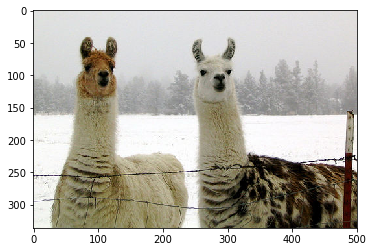

In [17]:
plt.imshow(img)

In [18]:
o = sess.run(tf.argmax(tf.nn.softmax(fc8)),feed_dict={inp:img,keep_prob:1.0})

ValueError: Cannot feed value of shape (336, 500, 3) for Tensor u'Placeholder:0', which has shape '(1, 256, 256, 3)'

In [19]:
img = scipy.misc.imresize(img,(256,256,3))

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.


In [20]:
img = img.reshape([1,256,256,3])

In [21]:
o = sess.run(tf.argmax(tf.nn.softmax(fc8),axis=1),feed_dict={inp:img,keep_prob:1.0})

In [22]:
o

array([957])

In [23]:
class_names[o[0]]

'pomegranate'

In [24]:
o = sess.run([conv5],feed_dict={inp:img,keep_prob:1.0})

In [25]:
o[0].shape

(1, 6, 6, 256)

In [27]:
data_dict = np.load('/root/Documents/EEL881-2018/bvlc_caffenet.npy',encoding = 'bytes').item()

In [28]:
for op_name in data_dict:
    print(op_name)
    with tf.variable_scope('alex_net', reuse=True) :
        with tf.variable_scope(op_name,reuse=True) as sc:
            for param_name in data_dict[op_name]:
                print(param_name)
                try:
                    var = tf.get_variable(param_name.decode('utf-8'))
                    data = data_dict[op_name][param_name]
                    sess.run(var.assign(data))
                except ValueError:
                    raise    

fc6
weights
biases
fc7
weights
biases
fc8
weights
biases
conv3
weights
biases
conv2
weights
biases
conv1
weights
biases
conv5
weights
biases
conv4
weights
biases


sess.close()
sess = tf.Session()

for v in tf.trainable_variables():
    para = v.eval(sess)
    print(v.name,np.mean(para))
    

In [29]:
o = sess.run(tf.argmax(tf.nn.softmax(fc8),axis=1),feed_dict={inp:img,keep_prob:1.0})
print(class_names[o[0]])

pedestal, plinth, footstall


In [30]:
img = scipy.misc.imread('/root/Documents/EEL881-2018/ell-881-2018-deep-learning/lec08/images/llama.jpeg')

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


In [31]:
img = scipy.misc.imresize(img,(256,256,3))
img = img-np.array([104., 117., 124.])

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``skimage.transform.resize`` instead.
  """Entry point for launching an IPython kernel.


In [32]:

img = img.reshape([1,256,256,3])

o = sess.run(tf.argmax(tf.nn.softmax(fc8),axis=1),feed_dict={inp:img,keep_prob:1.0})

class_names[o[0]]

'llama'

In [33]:
img = scipy.misc.imread('/root/Documents/EEL881-2018/ell-881-2018-deep-learning/lec08/images/llama.jpeg')
img.shape

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


(336, 500, 3)

In [34]:
img = img[32:256+32,70:256+70,:]
img = img-np.array([104., 117., 124.])
img.shape

(256, 256, 3)

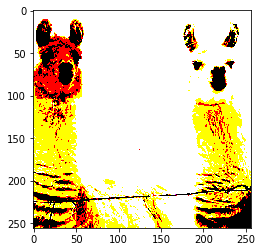

In [35]:
plt.imshow(img)

In [36]:

img = img.reshape([1,256,256,3])

o = sess.run(tf.argmax(tf.nn.softmax(fc8),axis=1),feed_dict={inp:img,keep_prob:1.0})

class_names[o[0]]

'West Highland white terrier'

In [37]:
sess.close()

In [41]:
img = scipy.misc.imread('/root/Documents/EEL881-2018/ell-881-2018-deep-learning/lec08/images/llama.jpeg')
img.shape

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imread`` instead.
  """Entry point for launching an IPython kernel.


(336, 500, 3)

In [42]:
inpLarge = tf.placeholder(tf.float32,[1,336,500,3])
keep_prob = tf.placeholder(tf.float32,None)
num_classes = 1000

In [43]:
with tf.variable_scope('pureCNN') as sc:
     # 1st Layer: Conv (w ReLu) -> Pool -> Lrn
    conv1 = conv(inpLarge, 11, 11, 96, 4, 4, padding = 'VALID', name = 'conv1')
    pool1 = max_pool(conv1, 3, 3, 2, 2, padding = 'VALID', name = 'pool1')
    norm1 = lrn(pool1, 2, 2e-05, 0.75, name = 'norm1')
    #self.conv1 = conv1
    # 2nd Layer: Conv (w ReLu) -> Pool -> Lrn with 2 groups
    conv2 = conv(norm1, 5, 5, 256, 1, 1, groups = 2, name = 'conv2')
    pool2 = max_pool(conv2, 3, 3, 2, 2, padding = 'VALID', name ='pool2')
    norm2 = lrn(pool2, 2, 2e-05, 0.75, name = 'norm2')
    #self.conv2 = conv2
    # 3rd Layer: Conv (w ReLu)
    conv3 = conv(norm2, 3, 3, 384, 1, 1, name = 'conv3')
    #self.conv3 = conv3
    # 4th Layer: Conv (w ReLu) splitted into two groups
    conv4 = conv(conv3, 3, 3, 384, 1, 1, groups = 2, name = 'conv4')
    #self.conv4 = conv4
    
    # 5th Layer: Conv (w ReLu) -> Pool splitted into two groups
    conv5 = conv(conv4, 3, 3, 256, 1, 1, groups = 2, name = 'conv5')
    #self.c5 = conv5
    pool5 = max_pool(conv5, 3, 3, 2, 2, padding = 'VALID', name = 'pool5')
    
    # 6th Layer: Flatten -> FC (w ReLu) -> Dropout
    #flattened = tf.reshape(pool5, [-1, 6*6*256])
    conv5 = pool5
    fc6c = conv(conv5,6,6,4096,1,1,padding = 'VALID',name = 'fc6_c')
    #fc6 = fc(flattened, 6*6*256, 4096, name='fc6')
    #dropout6 = dropout(fc6, keep_prob)
    
    # 7th Layer: FC (w ReLu) -> Dropout
    fc7c= conv(fc6c,1,1,4096,1,1,padding = 'VALID',name = 'fc7_c')
    #fc7 = fc(dropout6, 4096, 4096, name = 'fc7')
    #dropout7 = dropout(fc7, keep_prob)
    #self.fc7 = dropout7
    # 8th Layer: FC and return unscaled activations (for tf.nn.softmax_cross_entropy_with_logits)
    fc8c = conv(fc7c,1,1,num_classes,1,1,padding = 'VALID',name = 'fc8_c')
    #fc8 = fc(dropout7, 4096, num_classes, relu = False, name='fc8')

In [44]:
for v in tf.trainable_variables():
    print(v)

<tf.Variable 'alex_net/conv1/weights:0' shape=(11, 11, 3, 96) dtype=float32_ref>
<tf.Variable 'alex_net/conv1/biases:0' shape=(96,) dtype=float32_ref>
<tf.Variable 'alex_net/conv2/weights:0' shape=(5, 5, 48, 256) dtype=float32_ref>
<tf.Variable 'alex_net/conv2/biases:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'alex_net/conv3/weights:0' shape=(3, 3, 256, 384) dtype=float32_ref>
<tf.Variable 'alex_net/conv3/biases:0' shape=(384,) dtype=float32_ref>
<tf.Variable 'alex_net/conv4/weights:0' shape=(3, 3, 192, 384) dtype=float32_ref>
<tf.Variable 'alex_net/conv4/biases:0' shape=(384,) dtype=float32_ref>
<tf.Variable 'alex_net/conv5/weights:0' shape=(3, 3, 192, 256) dtype=float32_ref>
<tf.Variable 'alex_net/conv5/biases:0' shape=(256,) dtype=float32_ref>
<tf.Variable 'alex_net/fc6/weights:0' shape=(9216, 4096) dtype=float32_ref>
<tf.Variable 'alex_net/fc6/biases:0' shape=(4096,) dtype=float32_ref>
<tf.Variable 'alex_net/fc7/weights:0' shape=(4096, 4096) dtype=float32_ref>
<tf.Variable 'al

In [56]:
img = img.reshape([1,336,500,3])

In [57]:
sess = tf.Session()

In [58]:
sess.run(tf.global_variables_initializer())

In [59]:
o = sess.run(fc8c,feed_dict={inpLarge:img})

In [60]:
o.shape

(1, 4, 9, 1000)

In [61]:
data_dict = np.load('/root/Documents/EEL881-2018/bvlc_caffenet.npy',encoding = 'bytes').item()

In [62]:
for op_name in data_dict:
    with tf.variable_scope('pureCNN', reuse=True) :
        scope_op = op_name
        with tf.variable_scope(scope_op,reuse=True) as sc:
            for param_name in data_dict[op_name]:
                try:
                    p = param_name.decode('utf-8')
                    var = tf.get_variable(p)
                    data = data_dict[op_name][param_name]
                    #sess.run(var.assign(data))
                except ValueError:
                    raise 

ValueError: Variable pureCNN/fc6/weights does not exist, or was not created with tf.get_variable(). Did you mean to set reuse=tf.AUTO_REUSE in VarScope?

In [64]:
for op_name in data_dict:
    with tf.variable_scope('pureCNN', reuse=True) :
        scope_op = op_name
        if op_name == 'fc6':
            scope_op = 'fc6_c'
        if op_name == 'fc7':
            scope_op = 'fc7_c'
        if op_name == 'fc8':
            scope_op = 'fc8_c'
        
        with tf.variable_scope(scope_op,reuse=True) as sc:
            for param_name in data_dict[op_name]:
                try:
                    p = param_name.decode('utf-8')
                    var = tf.get_variable(p)
                    data = data_dict[op_name][param_name]
                    if op_name == 'fc6' and param_name == 'weights':
                        data = data.reshape([6,6,256,4096])
                    if op_name == 'fc7' and param_name == 'weights':
                        data = data.reshape([1,1,4096,4096])
                    if op_name == 'fc8' and param_name == 'weights':
                        data = data.reshape([1,1,4096,1000])
                    sess.run(var.assign(data))
                except ValueError:
                    raise 

In [65]:
o = sess.run(tf.argmax(fc8c,axis=3),feed_dict={inpLarge:img})


In [66]:
class_names = np.asarray(class_names)

In [67]:
class_names[o[0].flatten()]

array(['llama', 'wire-haired fox terrier', 'llama', 'llama', 'llama',
       'llama', 'llama', 'llama', 'llama', 'llama',
       'pedestal, plinth, footstall', 'llama', 'llama', 'llama', 'llama',
       'llama', 'llama', 'llama', 'pedestal, plinth, footstall',
       'pedestal, plinth, footstall',
       'toilet tissue, toilet paper, bathroom tissue',
       'ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus',
       'llama', 'llama', 'llama', 'llama', 'llama', 'gown',
       'jean, blue jean, denim', 'candle, taper, wax light',
       'paper towel', 'paper towel',
       'ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus',
       'ice bear, polar bear, Ursus Maritimus, Thalarctos maritimus',
       'broom', 'broom'], dtype='|S121')

In [ ]:
#img = img-np.array([104., 117., 124.])